<a id='home'></a>
### purpose

why do GF runs using 500 markers do about as well as runs using 10k-20k markers? here I look to see if those 500 pick up on population structure in a similar way that larger sets of loci would have. If the 500-loci set picks up on similar pop structure, there should be highly correlated distances in PC space amoung populations

### notes

I didn't compare 500 to 20000 because some sims have fewer than 20k loci, so comparing to 10k is probably fine

### outline

1. [estimate PCs with locus data](#est)
    1. [get snp data](#snp)
    1. [estimate PCs](#pca)
1. [calc correlation of PC loadings](#calc)
1. [make figs](#figs)
1. [print out percentiles](#print)

In [1]:
from pythonimports import *
import myfigs as mf

import runtime_API as rt

from sklearn.decomposition import PCA

lview, dview = get_client(cluster_id='1710954656-wtze', profile='lotterhos')

save_dir = makedir(f'{rt.resdir}/supp_figs/05/01_pca_distance')

t0 = dt.now()  # notebook timer

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	March 20, 2024 - 14:45:14 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 8b790072e7a46d7f58a30c40cf4660986a612764  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 2 13:55:49 2024 -0500

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='est'></a>
# estimate PCs with locus data

[top](#home)

<a id='snps'></a>
### get the snpfiles

In [2]:
# get snpfiles for 500, 5000, 10000, and 20k snp sets
snpfiles = wrap_defaultdict(list, 2)
for (source, rep), repdirs in unwrap_dictionary(rt.dirs):
    for repdir in pbar(repdirs, desc=f'{source} {rep}'):
        num_loci = op.basename(repdir)
        snpdir = f'{repdir}/gradient_forests/training/training_files'
        files = fs(snpdir, endswith=f'_Rout_Gmat_sample_maf-gt-p01_GFready_{source}_all.txt')

        assert len(files) == 225
        
        for snpfile in files:
            seed = op.basename(snpfile).split("_")[0]
            if seed in rt.seeds:
                snpfiles[source][seed].append(snpfile)
        

pooled run_20220919_450-675: 100%|███████████████| 4/4 [00:00<00:00, 12.18it/s]


In [3]:
len(snpfiles['ind']), len(snpfiles['pooled'])

(540, 540)

In [4]:
for (source, seed), files in unwrap_dictionary(snpfiles):
    assert len(files) == 4

<a id='pca'></a>
### estimate pca

[top](#home)

In [5]:
def do_pca(snpfile, n_components=3):
    """Run principal component analysis."""
    from sklearn.decomposition import PCA
    import pandas as pd
    
    data = pd.read_table(snpfile, index_col='index')
    
    loadings_pca = PCA(n_components=n_components).fit_transform(data)
    pca_loadings = pd.DataFrame(loadings_pca, index=data.index)
    
    return pca_loadings


def get_pcas(snpfiles):
    pca_loadings = {}
    for snpfile in snpfiles:
        num_loci = snpfile.split('/')[6].lstrip('0')
        assert float(num_loci) == int(num_loci)
        
        pca_loadings[num_loci] = do_pca(snpfile)
        
    return pca_loadings

dview['do_pca'] = do_pca

In [6]:
# estimate PCA loadings in parallel

jobs = []
args = []
for (source, seed), files in unwrap_dictionary(snpfiles):
    args.append((source, seed))
    
    jobs.append(
        lview.apply_async(
            get_pcas, files
        )
    )
    
watch_async(jobs)


Watching 1080 jobs ...


100%|███████████████| 1080/1080 [22:53<00:00,  1.27s/it]


In [7]:
# save loadings for easy loading
pca_loadings = defaultdict(dict)
for i, j in enumerate(jobs):
    source, seed = args[i]
    pca_loadings[source][seed] = j.r
    
pkl = f'{save_dir}/pca_loadings.pkl'
pkldump(pca_loadings, pkl)

pkl

'/work/lotterhos/brandon/runtime/supp_figs/05/01_pca_distance/pca_loadings.pkl'

<a id='calc'></a>
# calc correlation of PC loadings

[top](#home)

In [8]:
# calc correlation of PC loadings between 500-loci PCs and 10k-loci PCs
corrs = wrap_defaultdict(list, 2)
for source, seeds in pca_loadings.items():
    for seed in pbar(seeds, desc=source):
        loadings = pca_loadings[source][seed]
        
        l_corr = loadings['500'].corrwith(loadings['10000'], method='pearson')
        
        for pc, corr in l_corr.items():
            corrs[source][pc].append(
                corr
            )

pooled: 100%|███████████████| 540/540 [00:02<00:00, 249.63it/s]


<a id='figs'></a>
# make figs

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/supp_figs/05/01_pca_distance/pc_corrs_500_vs_10000.pdf


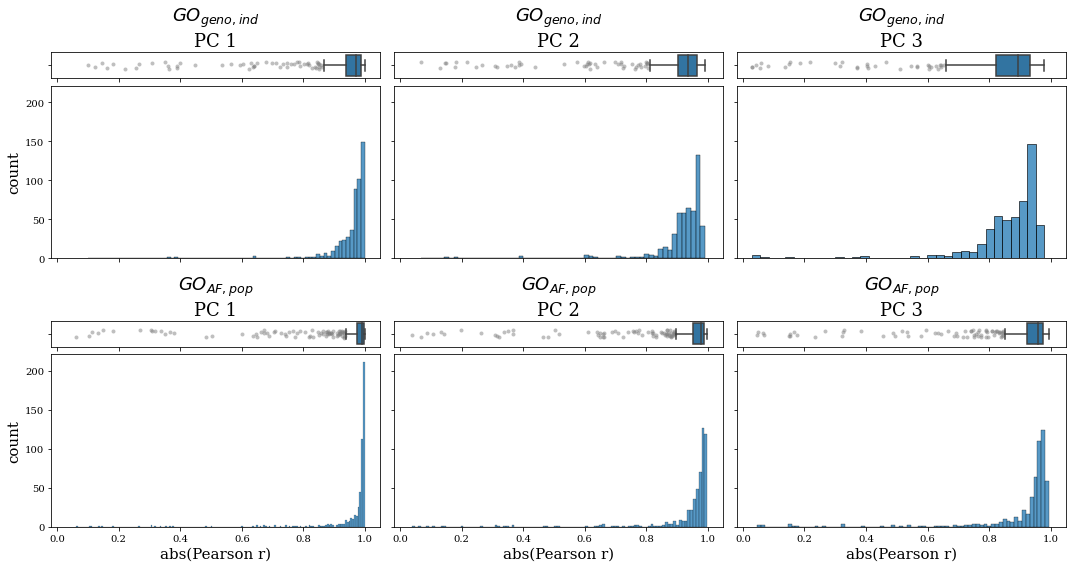

In [9]:
# make a fig
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)

i = 0
for source, pc_data in corrs.items():
    row_axes = axes[i]

    for pc, vals in pc_data.items():
        ax_box, ax_hist = mf.histo_box(
            pd.Series(vals).abs(),
            ax=row_axes[pc]
        )
        
        ax_hist.set_xlabel(
            f'abs(Pearson r)', # '\nr(500-loci PC {pc +1} loadings, 10000-loci PC {pc +1} loadings)',
            fontsize=15
        )
        
        ax_box.set_title(f'{rt.factor_names[source]}\nPC {pc + 1}', fontsize=18)
        
        if pc == 0:
            ax_hist.set_ylabel('count', fontsize=15)

    i += 1
    
plt.tight_layout()
mf.save_pdf(f'{save_dir}/pc_corrs_500_vs_10000.pdf')
plt.show()

<a id='print'></a>
# print out percentiles

[top](#home)

In [10]:
for source, pc_data in corrs.items():

    for pc, vals in pc_data.items():
        vals = pd.Series(vals).abs()
        print(ColorText(f'\n{source} PC = {pc + 1}').bold())
        print('median = ', vals.median())
        print('10th percentile = ', vals.quantile(0.1))
        print('20th percentile = ', vals.quantile(0.2))


ind PC = 1
median =  0.9711127712581895
10th percentile =  0.8657920770672326
20th percentile =  0.9258464735327009

ind PC = 2
median =  0.9349123724433615
10th percentile =  0.8377649286525317
20th percentile =  0.8941835637455453

ind PC = 3
median =  0.8922288676585349
10th percentile =  0.7310691438053912
20th percentile =  0.8060709099099943

pooled PC = 1
median =  0.9914726714876498
10th percentile =  0.8907010393549494
20th percentile =  0.9589206977090595

pooled PC = 2
median =  0.9770345721622186
10th percentile =  0.8687872498622771
20th percentile =  0.939740808189142

pooled PC = 3
median =  0.9600802020478258
10th percentile =  0.8263537525643313
20th percentile =  0.9095359739605574


In [11]:
formatclock(dt.now() - t0)

'0-00:23:06'

# remake fig

need to change workflow to model (GF_AF or GF_geno) and i didn't want to wait to rerun the notebook

In [1]:
from pythonimports import *
import myfigs as mf

import runtime_API as rt

save_dir = f'{rt.resdir}/supp_figs/05/01_pca_distance'

t0 = dt.now()  # notebook timer

rt.latest_commit()
session_info.show()

#########################################################
Today:	September 26, 2024 - 11:11:34 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



In [2]:
# reload data
pkl = f'{save_dir}/pca_loadings.pkl'

pca_loadings = pklload(pkl)

In [3]:
# re-calc correlation of PC loadings between 500-loci PCs and 10k-loci PCs
corrs = wrap_defaultdict(list, 2)
for source, seeds in pca_loadings.items():
    for seed in pbar(seeds, desc=source):
        loadings = pca_loadings[source][seed]
        
        l_corr = loadings['500'].corrwith(loadings['10000'], method='pearson')
        
        for pc, corr in l_corr.items():
            corrs[source][pc].append(
                corr
            )

pooled: 100%|███████████████| 540/540 [00:02<00:00, 256.35it/s]


Saved to:  /work/lotterhos/brandon/runtime/supp_figs/05/01_pca_distance/pc_corrs_500_vs_10000_correct.pdf


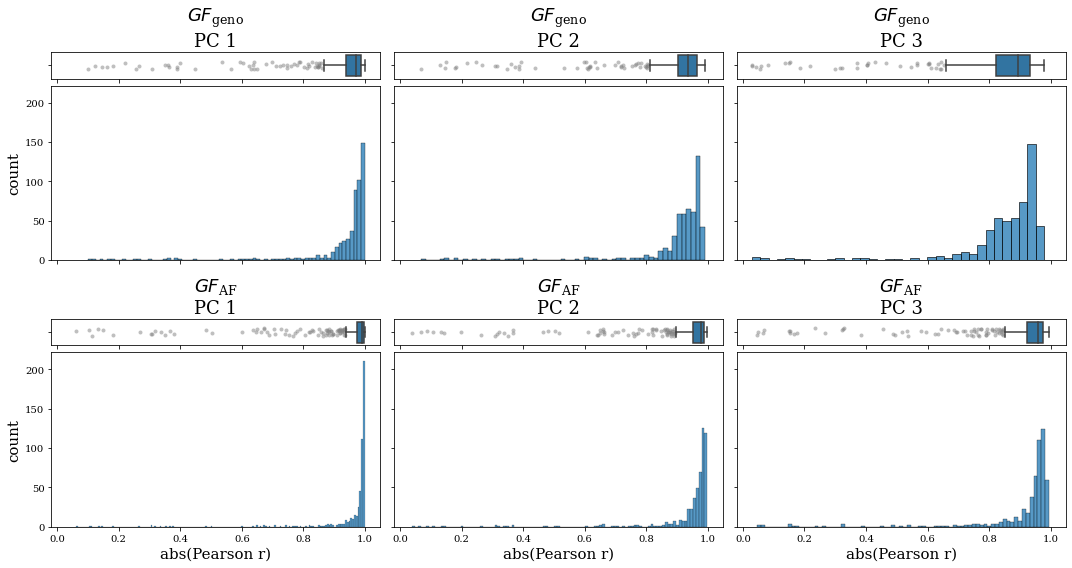

In [4]:
# remake a fig
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 8), sharex=True, sharey=True)

i = 0
for source, pc_data in corrs.items():
    row_axes = axes[i]
    
    model = 'geno-model' if source == 'ind' else 'af-model'

    for pc, vals in pc_data.items():
        ax_box, ax_hist = mf.histo_box(
            pd.Series(vals).abs(),
            ax=row_axes[pc]
        )
        
        ax_hist.set_xlabel(
            f'abs(Pearson r)', # '\nr(500-loci PC {pc +1} loadings, 10000-loci PC {pc +1} loadings)',
            fontsize=15
        )
        
        ax_box.set_title(f'{rt.factor_names[model]}\nPC {pc + 1}', fontsize=18)
        
        if pc == 0:
            ax_hist.set_ylabel('count', fontsize=15)

    i += 1
    
plt.tight_layout()
mf.save_pdf(f'{save_dir}/pc_corrs_500_vs_10000_correct.pdf')
plt.show()

In [5]:
formatclock(dt.now() - t0)

'0-00:00:09'